# Fitting Parameters for Influenza Data

## Overview

This is a study of the Influenza data. The analysis provides plots of fits and parameter estimates. Two models are considered.

 only have some minor cosmetic suggestions:
In the Overview section, "since volunteer exposure" could be rephrased to "since the exposure of the volunteers to an attenuated strain of H1N1"
And maybe in Section 1 (Data setup)  one could add a reference to the article I sourced the data from:

Baccam P et al., Kinetics of Influenza A Virus Infection in Humans. Journal of Virology. 2006 Aug 1;80(15):7590–9.
Influenza A (WT HK/123/77 (H1N1)) data from Table 1.

### Influenza Data (Influenza.csv)

- 6 patients
- Viral levels in log10(TCID50 / ml of nasal wash)
- Measurements taken a successive days since volunteer exposure
- Columns are patients

### State variables

- $T$: number of target cells
- $E$: number of exposed cells (virus replicating inside, not yet spreading virus)
- $I$: number of infected cells (active virus production)
- $V$: viral titre, in units of TCID50/ml of biofluid wash (for Influenza)

### Baseline Model: $T \rightarrow E \rightarrow I \rightarrow \emptyset$
 $\frac{dT}{dt} = - \beta T V$
 
 $\frac{dE}{dt} =  \beta T V - \kappa E$
 
 $\frac{dI}{dt} = \kappa E - \delta I$
 
 $\frac{dV}{dt} = p y(I) - c y(V)$
 
### Simplified Model: $T \rightarrow I \rightarrow \emptyset$
 $\frac{dT}{dt} = - \beta T V$
 
 $\frac{dI}{dt} = \beta T V - \delta I$
 
 $\frac{dV}{dt} = p y(I) - c y(V)$
 

In [1]:
# Python packages used
import os
import numpy as np
import pandas as pd
import SBstoat
from SBstoat.modelStudy import ModelStudy
%matplotlib inline

In [2]:
# Programming Constants Used in Analysis. Constants are in all capital letters.
USE_SERIALIZED = False  # Use saved values of fitting from a previous bootstrap (if present)
DO_SERIALIZE = True  # Update the saved values of fitted data
DIR = "/home/ubuntu/SBstoat/examples/virus"  # Directory where the data are
FILE_NAME = "Influenza.csv"  # Name of the file containing the observed data
NUM_BOOTSTRAP_ITERATION = 10000  # Number of bootstrap iterations, if bootstrapping is done
VIRUS = "log10V"  # Name of the state variable that corresponds to the observed data

## Study for Baseline Model

In [3]:
ANTIMONY_MODEL  = '''
    // Equations
    E1: T -> E ; beta*T*V ; // Target cells to exposed
    E2: E -> I ; kappa*E ;  // Exposed cells to infected
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    kappa = 4.0;    // rate of transition from exposed(E) to infected(I) cells, in units of 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    E = 0
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection
    
    // Computed values
    log10V := log10(V)

'''

### 1. Data Setup
The input data provided is:

``
2,5.5,4,5.5,3,0,0
1,6,3,1.5,3.5,1.3,0
2.5,5,5,3,5.5,3.5,0
3.5,5.5,6.5,5.5,3.5,4,0
2.5,3,6.5,6.5,2,0.8,0
4,5,5.5,7.5,5.5,1.3,0
``

The rows are patients; the columns are times. We need to create separate data for each patient.

In [4]:
# Transform the input data into separate data sources.
path = os.path.join(DIR, FILE_NAME)
patients = ["P1", "P2", "P3", "P4", "P5", "P6"]
dataSourceDct = SBstoat.modelStudy.mkDataSourceDct(path, VIRUS,
                                                   dataSourceNames=patients, isTimeColumns=True)

In [5]:
# dataSourceDct is a python dictionary. The key is 'Pn', where n is the patient number.
# The value is a time series for that patient.
dataSourceDct

{'P1':       log10V
 time        
 0.0      2.0
 1.0      5.5
 2.0      4.0
 3.0      5.5
 4.0      3.0
 5.0      0.0
 6.0      0.0,
 'P2':       log10V
 time        
 0.0      1.0
 1.0      6.0
 2.0      3.0
 3.0      1.5
 4.0      3.5
 5.0      1.3
 6.0      0.0,
 'P3':       log10V
 time        
 0.0      2.5
 1.0      5.0
 2.0      5.0
 3.0      3.0
 4.0      5.5
 5.0      3.5
 6.0      0.0,
 'P4':       log10V
 time        
 0.0      3.5
 1.0      5.5
 2.0      6.5
 3.0      5.5
 4.0      3.5
 5.0      4.0
 6.0      0.0,
 'P5':       log10V
 time        
 0.0      2.5
 1.0      3.0
 2.0      6.5
 3.0      6.5
 4.0      2.0
 5.0      0.8
 6.0      0.0,
 'P6':       log10V
 time        
 0.0      4.0
 1.0      5.0
 2.0      5.5
 3.0      7.5
 4.0      5.5
 5.0      1.3
 6.0      0.0}

### 2. Transform the simulation results to units of observed values
The observed values are in units of log10. So, simulation results must
be converted to these units. This is done by using an assignment rule in the simulation model.
For this model, the assignmnt rule is ``log10V := log10(V)``.

### 3. Specify permissible values for parameters
For each parameter, provide a tuple of its: lower bound, upper bound, and starting value.

In [6]:
# Parameter value ranges: lower, upper, initial value
parameterDct = dict(
      beta=(0, 10e-5, 3.2e-5),
      kappa=(0, 10, 4.0),
      delta=(0, 10, 5.2),
      p=(0, 1, 4.6e-2),
      c=(0, 10, 5.2)
      )

### 4. Run the model and produce plots.

In [7]:
# Run a study
def runStudy(model, dirStudyPath, filterSL=None):
    study = ModelStudy(model,                     # Antimony model to evaluate
                   dataSourceDct,                 # Data sources to use for fitting
                   parameterDct=parameterDct,     # Parameters and their value ranges
                   dirStudyPath=dirStudyPath,     # Where to store the results of bootstrapping
                   selectedColumns=["log10V"],    # Output column is computed in the assignment rule
                   doSerialize=DO_SERIALIZE,      # Save the results of bootstrapping
                   useSerialized=USE_SERIALIZED)  # Use previously calculated bootstrap results if they are present

    study.bootstrap(numIteration=NUM_BOOTSTRAP_ITERATION, filterSL=filterSL)  # Do bootstrapping
    print("\n\n")
    study.plotFitAll()                                     # Plot fitted and observed values with band plots for confidence
    print("\n\n")
    study.plotParameterEstimates()                         # Plot the parameter estimates for each data source




0.082981: ***Doing bootstrapp for instance P1***


0.239644: ***Running bootstrap for 10000 iterations with 4 processes.***
0.616258:     (Process 3: Fit has high chisq: 75.35 on iteration 1.)
0.788321:     (Process 2: Fit has high chisq: 61.22 on iteration 3.)
1.112735:     (Process 2: Fit has high chisq: 47.59 on iteration 6.)
1.268992:     (Process 1: Fit has high chisq: 45.57 on iteration 8.)
1.553959:     (Process 2: Fit has high chisq: 66.16 on iteration 10.)
1.610120:     (Process 3: Fit has high chisq: 52.67 on iteration 11.)
1.693677:     (Process 2: Fit has high chisq: 38.10 on iteration 11.)
1.832158:     (Process 2: Fit has high chisq: 68.24 on iteration 12.)
2.197923:     (Process 0: Fit has high chisq: 60.28 on iteration 17.)
2.323673:     (Process 0: Fit has high chisq: 95.36 on iteration 18.)
2.835067:     (Process 3: Fit has high chisq: 61.22 on iteration 23.)
2.960492:     (Process 3: Fit has high chisq: 44.40 on iteration 24.)
3.142857:     (Process 2: Fit has high

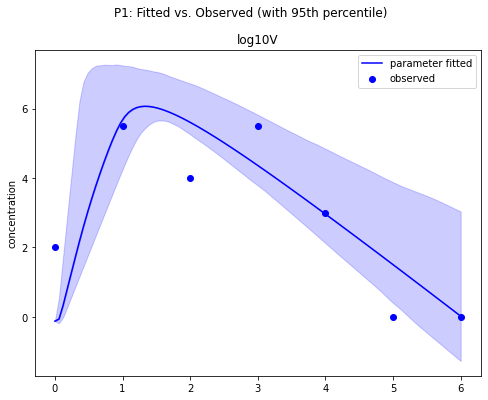

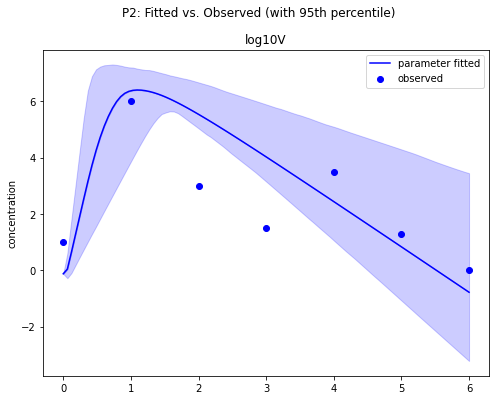

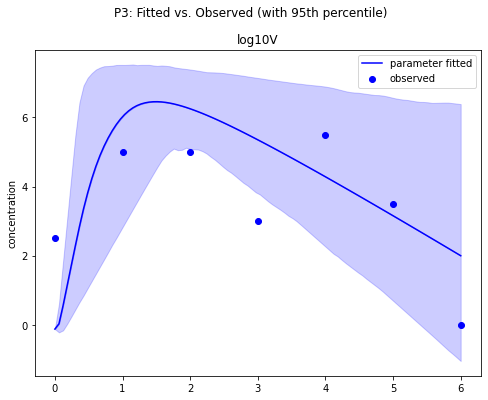

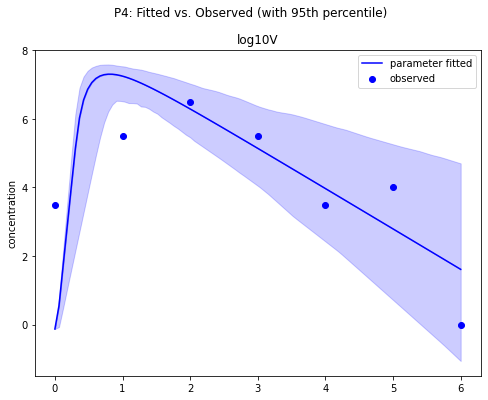

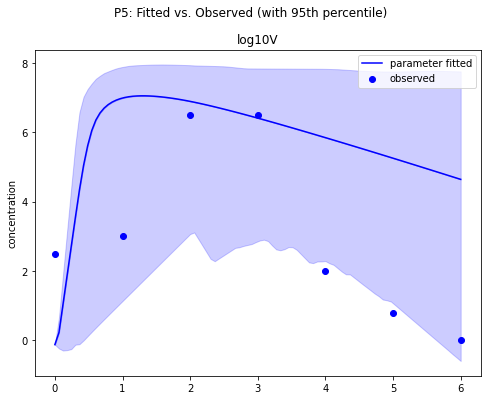

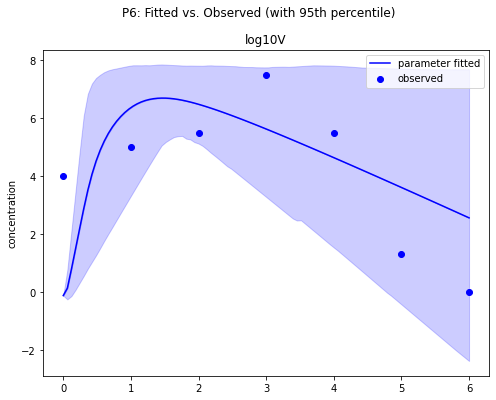

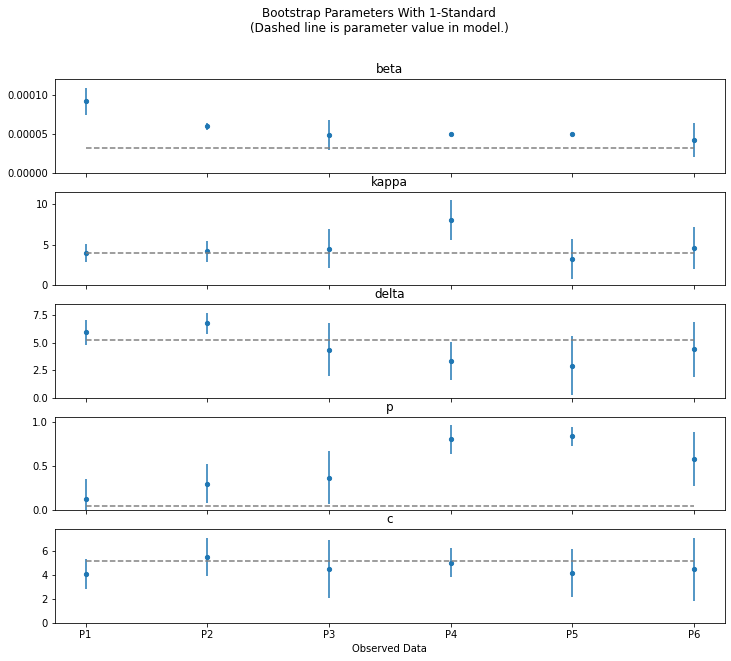

In [8]:
dirStudyPath = os.path.join(DIR, "ModelStudyFitters_1")
runStudy(ANTIMONY_MODEL, dirStudyPath, filterSL=0.01)



2076.950914: ***Doing bootstrapp for instance P1***


2077.073613: ***Running bootstrap for 10000 iterations with 4 processes.***
2077.554254:     (Process 1: Fit has high chisq: 60.00 on iteration 2.)
2077.664222:     (Process 2: Fit has high chisq: 66.02 on iteration 3.)
2077.685208:     (Process 1: Fit has high chisq: 54.69 on iteration 3.)
2077.891948:     (Process 3: Fit has high chisq: 35.17 on iteration 5.)
2078.069102:     (Process 0: Fit has high chisq: 66.78 on iteration 8.)
2078.238452:     (Process 2: Fit has high chisq: 111.19 on iteration 8.)
2078.324735:     (Process 1: Fit has high chisq: 115.70 on iteration 9.)
2078.552906:     (Process 1: Fit has high chisq: 63.95 on iteration 11.)
2078.627475:     (Process 2: Fit has high chisq: 66.78 on iteration 11.)
2078.780048:     (Process 1: Fit has high chisq: 64.51 on iteration 13.)
2079.000405:     (Process 1: Fit has high chisq: 71.63 on iteration 15.)
2079.342627:     (Process 3: Fit has high chisq: 26.62 on iteration 19

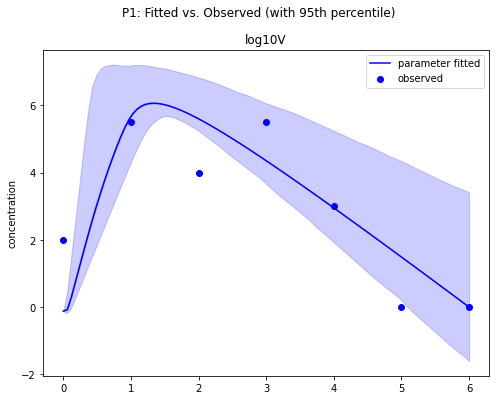

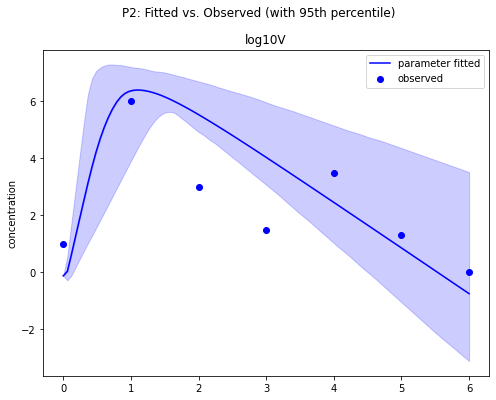

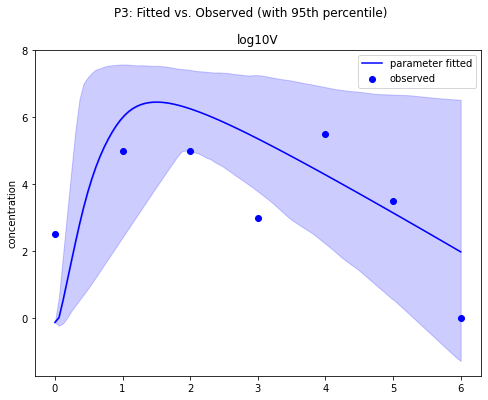

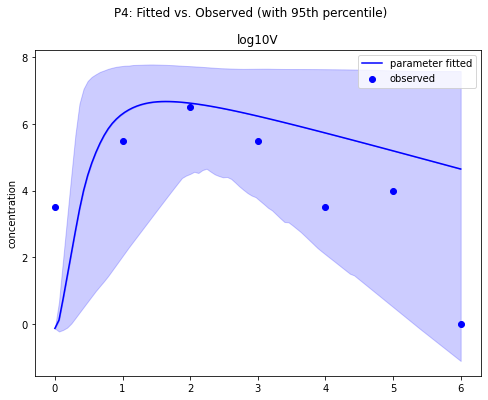

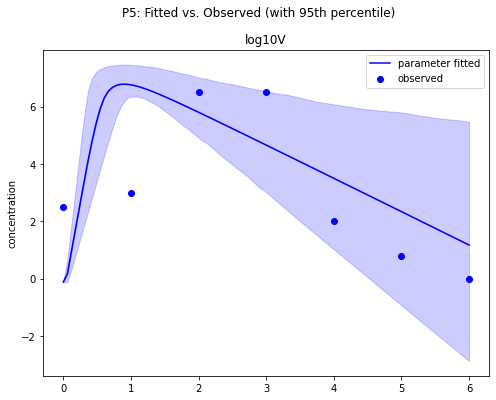

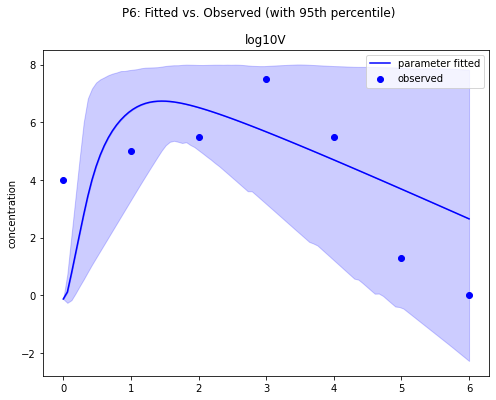

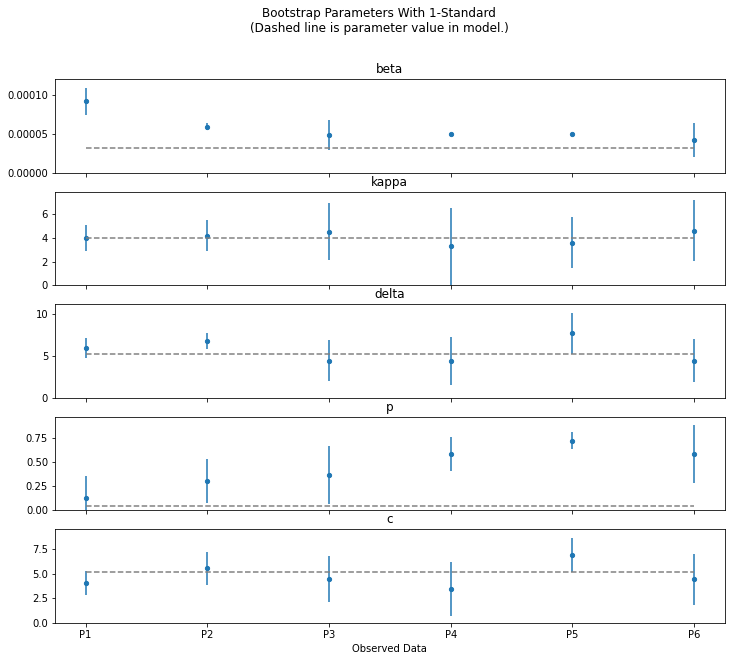

In [9]:
dirStudyPath = os.path.join(DIR, "ModelStudyFitters_01")
runStudy(ANTIMONY_MODEL, dirStudyPath, filterSL=0.01)

## Simplified Model: $T \rightarrow I \rightarrow \emptyset$
The model is updated to remove the state variable E and the parameter $\kappa$.

In [10]:
# Parameter value ranges: lower, upper, initial value
parameterDct = dict(
      beta=(0, 10e-5, 3.2e-5),
      delta=(0, 10, 5.2),
      p=(0, 1, 4.6e-2),
      c=(0, 10, 5.2)
      )

In [11]:
SIMPLIFIED_MODEL  = '''
    // Equations
    E1: T -> I ; beta*T*V ; // Target cells to exposed
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection
    
     // Computed values
    log10V := log10(V)

'''

### Step 4: Run the model and produce plots



4200.783742: ***Doing bootstrapp for instance P1***


4200.947110: ***Running bootstrap for 10000 iterations with 4 processes.***
4201.220666:     (Process 0: Fit has high chisq: 37.35 on iteration 0.)
4201.237568:     (Process 2: Fit has high chisq: 20.82 on iteration 0.)
4201.695668:     (Process 3: Fit has high chisq: 19.53 on iteration 5.)
4201.769370:     (Process 2: Fit has high chisq: 91.81 on iteration 5.)
4201.828327:     (Process 0: Fit has high chisq: 52.05 on iteration 6.)
4201.902615:     (Process 2: Fit has high chisq: 45.00 on iteration 6.)
4202.021794:     (Process 3: Fit has high chisq: 71.56 on iteration 8.)
4202.050970:     (Process 0: Fit has high chisq: 33.75 on iteration 8.)
4202.119473:     (Process 1: Fit has high chisq: 20.70 on iteration 8.)
4202.166221:     (Process 3: Fit has high chisq: 79.06 on iteration 9.)
4202.209124:     (Process 0: Fit has high chisq: 50.45 on iteration 9.)
4202.528967:     (Process 1: Fit has high chisq: 88.89 on iteration 12.)
420

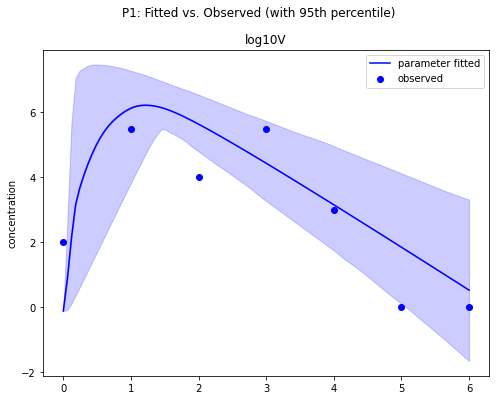

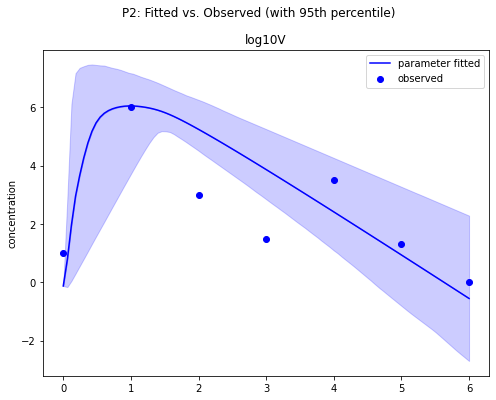

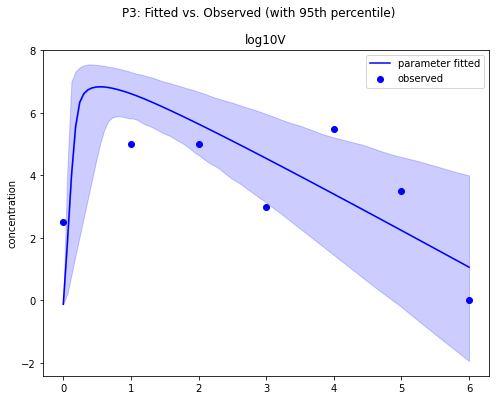

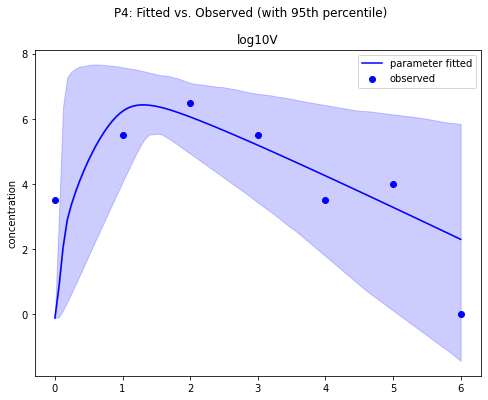

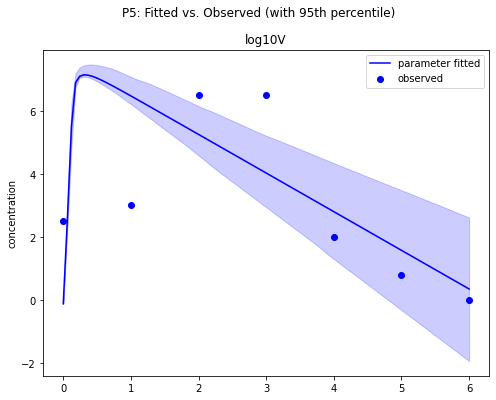

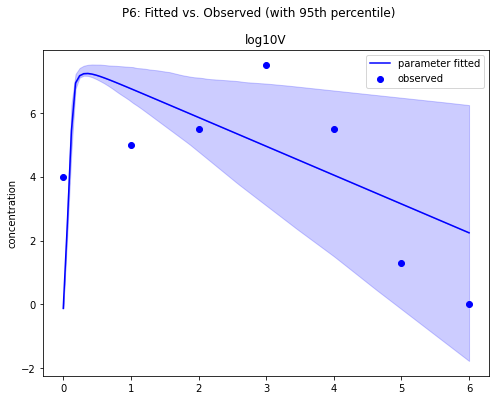

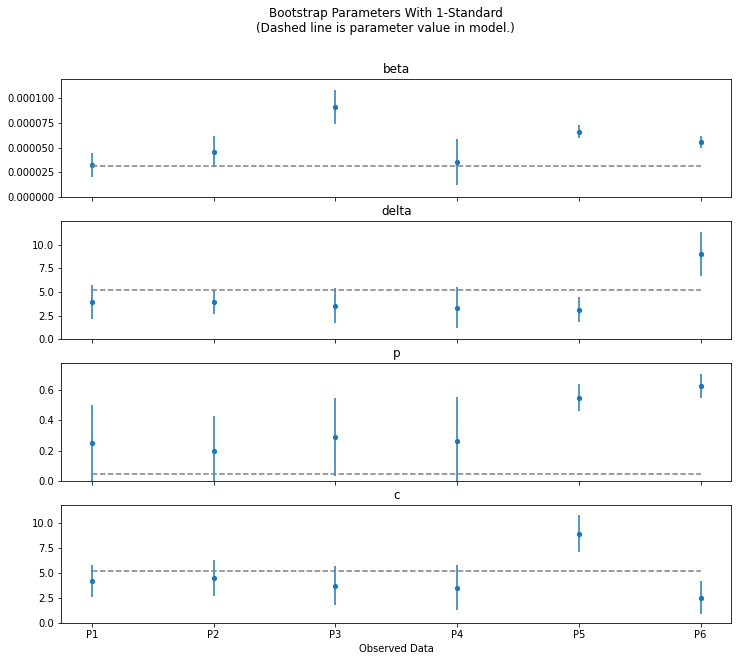

In [12]:
dirStudyPath = os.path.join(DIR, "SimpleModelFitters_1")
runStudy(SIMPLIFIED_MODEL, dirStudyPath, filterSL=0.1)



5966.363031: ***Doing bootstrapp for instance P1***


5966.478982: ***Running bootstrap for 10000 iterations with 4 processes.***
5966.743819:     (Process 0: Fit has high chisq: 56.62 on iteration 0.)
5966.859882:     (Process 3: Fit has high chisq: 23.70 on iteration 1.)
5967.033358:     (Process 1: Fit has high chisq: 43.87 on iteration 3.)
5967.100057:     (Process 3: Fit has high chisq: 17.01 on iteration 3.)
5967.440205:     (Process 0: Fit has high chisq: 28.42 on iteration 4.)
5967.605296:     (Process 1: Fit has high chisq: 35.20 on iteration 6.)
5967.645571:     (Process 2: Fit has high chisq: 28.98 on iteration 6.)
5967.892577:     (Process 3: Fit has high chisq: 42.69 on iteration 9.)
5968.023977:     (Process 3: Fit has high chisq: 170.94 on iteration 10.)
5968.241470:     (Process 3: Fit has high chisq: 29.50 on iteration 12.)
5968.571651:     (Process 3: Fit has high chisq: 17.44 on iteration 15.)
5968.626427:     (Process 0: Fit has high chisq: 18.27 on iteration 16.)

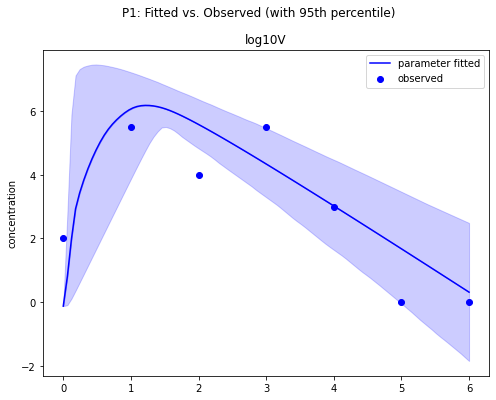

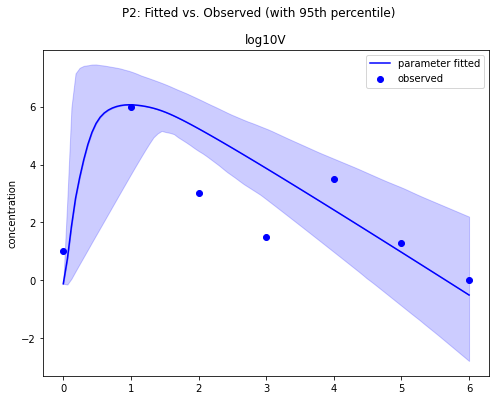

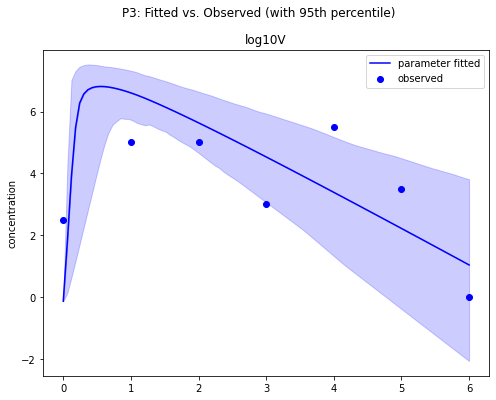

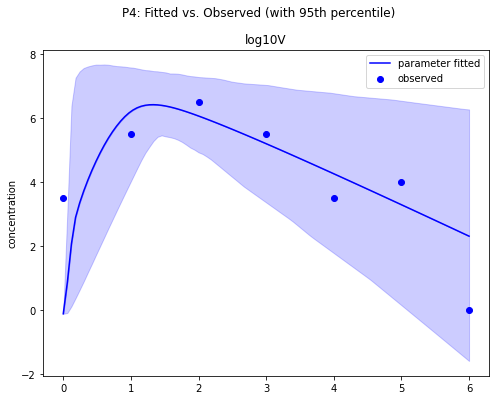

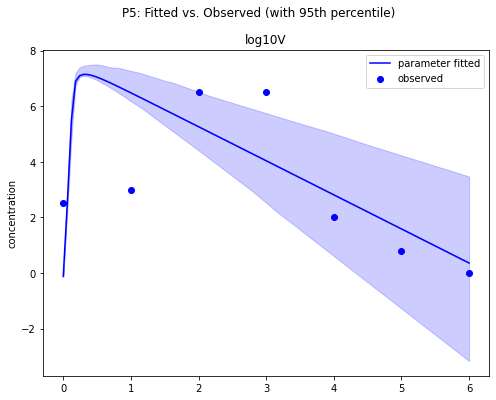

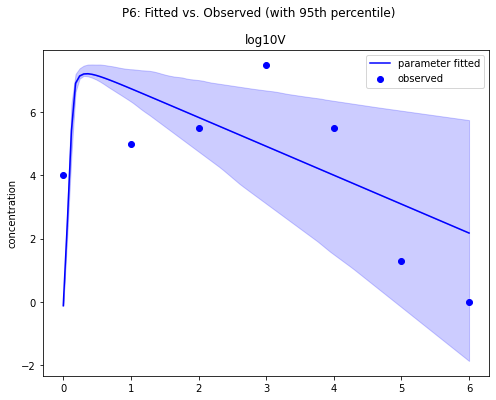

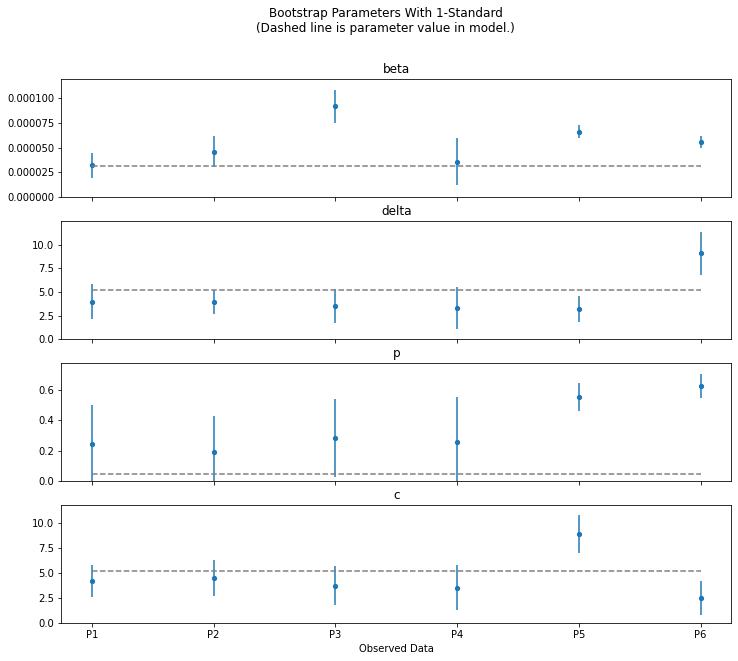

In [13]:
dirStudyPath = os.path.join(DIR, "SimpleModelFitters_01")
runStudy(SIMPLIFIED_MODEL, dirStudyPath, filterSL=0.01)